# Building a STAC Catalogue in Zarr
his notebook demonstrates how to build a STAC catalogue using the Zarr format. Zarr is an efficient, scalable format for the storage of chunked, compressed, N-dimensional arrays. This notebook will guide you through the steps to create, manipulate, and visualize a STAC catalogue in Zarr.

In [71]:
import earthkit.data

## STAC catalogue
In this section we will explore how to build a STAC catalogue, and which are its main features

In [72]:
import os
import json
import rasterio
import urllib.request
import pystac
import pandas as pd

from datetime import datetime, timezone
from shapely.geometry import Polygon, mapping
from tempfile import TemporaryDirectory

In [73]:
# List of dates from 2004-01-01 to 2004-01-31 (use pandas to generate this)
dates = pd.date_range(start='2004-01-01', end='2004-03-31', freq='D').strftime('%Y-%m-%d').tolist()

In [ ]:
# Set temporary directory to store source data
tmp_dir = TemporaryDirectory()

ds = earthkit.data.from_source("cds",
                                    f"reanalysis-era5-single-levels",
                                    variable=["2m_temperature"],
                                    product_type="reanalysis",
                                    area=[46, 6, 44, 8], 
                                    grid=[0.25, 0.25],
                                    date=dates,
                                    time=["00:00", "03:00", "06:00","09:00", "12:00", "15:00","18:00", "21:00"]
                                )

2024-10-15 14:46:43,068 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-10-15 14:46:43,083 WARNING [2024-09-26T00:00:00] Should you have not yet migrated from the old CDS system to the new CDS, please check our [informative page](https://confluence.ecmwf.int/x/uINmFw) for guidance.
2024-10-15 14:46:43,083 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-10-15 14:46:43,083 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-10-15 14:46:43,083 WARNING [2024-06-16T

In [65]:
catalog = pystac.Catalog(id='tutorial-catalog', description='This catalog is a basic demonstration catalog utilizing a file from CDS ERA5 on single levels.')

collection = pystac.Collection(
    id="era5-temperature-zarr",
    description="ERA5 reanalysis temperature data in Zarr format",
    extent=pystac.Extent(
        spatial=pystac.SpatialExtent([[-180.0, -90.0, 180.0, 90.0]]),
        temporal=pystac.TemporalExtent([[datetime(2020, 1, 1), datetime(2020, 12, 31)]])
    ),
    license="CC-BY-4.0"
)

In [66]:
# Get all the coordinates latitude/longitude in the ds.to_xarray()
latitudes = ds.to_xarray().latitude.values
longitudes = ds.to_xarray().longitude.values


import os
import pystac
from datetime import datetime, timezone
import numpy as np

import os
import pystac
from datetime import datetime, timezone
import numpy as np

# Itera su latitudine e longitudine
for lat in latitudes:
    for lon in longitudes:

        tmp_path = os.path.join(tmp_dir.name, f'example_{lat}_{lon}.zarr')
        # Rechunck and store data
        ds.to_xarray().sel(latitude=lat, longitude=lon, method='nearest').chunk(chunks={'time': -1}).to_zarr(tmp_path)

        # Converte lat e lon in float per garantire la serializzazione JSON
        lat = float(lat)
        lon = float(lon)

        

        # Crea un nuovo item STAC
        item = pystac.Item(
            id=f'era5-prova-{lat}-{lon}',  # Usa lat e lon nel nome per un ID univoco
            geometry={
                "type": "Point",
                "coordinates": [lon, lat]  # Assicurati che siano float
            },
            bbox=[float(lon), float(lat), float(lon), float(lat)],  # Converti anche il bbox
            datetime=datetime.now(timezone.utc),
            properties={}
        )
        
        # Aggiunge l'asset e tutte le informazioni all'item
        item.add_asset(
            key='data',
            asset=pystac.Asset(
                href=tmp_path,
                media_type="application/vnd+zarr",
                roles=["data"]
            )
        )

        # Aggiunge l'item alla collection
        collection.add_item(item)

# Aggiunge la collection al catalogo
catalog.add_child(collection)

# Salva il catalogo STAC in locale
catalog.normalize_and_save("era5_zarr_catalog", catalog_type=pystac.CatalogType.SELF_CONTAINED)

In [67]:
catalog = pystac.Catalog.from_file('era5_zarr_catalog/catalog.json')

In [68]:
from rtree import index
from shapely.geometry import shape, Point
from shapely.ops import nearest_points

# Crea un indice spaziale
spatial_index = index.Index()

# Popola l'indice con gli item del catalogo
item_map = {}
for idx, item in enumerate(catalog.get_all_items()):
    if item.geometry:
        item_geometry = shape(item.geometry)
        spatial_index.insert(idx, item_geometry.bounds)
        item_map[idx] = item

# Definisci il punto griglia
latitude = 45
longitude = 8
point_of_interest = Point(longitude, latitude)

# Cerca gli item che intersecano il punto
matching_indices = list(spatial_index.intersection((longitude, latitude, longitude, latitude)))

# Se non troviamo nessun item corrispondente, cerchiamo il più vicino
if matching_indices:
    # Otteniamo gli item corrispondenti
    matching_items = [item_map[idx] for idx in matching_indices]
else:
    # Se non ci sono corrispondenze esatte, calcoliamo l'item più vicino
    min_distance = float('inf')
    closest_item = None

    # Iteriamo su tutti gli item per trovare quello più vicino
    for idx, item in item_map.items():
        item_geometry = shape(item.geometry)
        # Trova i punti più vicini tra il punto griglia e l'item corrente
        nearest = nearest_points(item_geometry, point_of_interest)
        distance = point_of_interest.distance(nearest[0])

        # Aggiorna l'item più vicino
        if distance < min_distance:
            min_distance = distance
            closest_item = item

    # Aggiungi l'item più vicino alla lista dei matching items
    matching_items = [closest_item]

# Visualizza l'Item trovato (o il più vicino)
for item in matching_items:
    print(f'Coordinates: {item.geometry['coordinates']}')
    print(f"Item ID: {item.id}")
    print(f"Assets: {item.assets}")


Coordinates: [8.0, 45.0]
Item ID: era5-prova-45.0-8.0
Assets: {'data': <Asset href=C:/Users/jacop/AppData/Local/Temp/tmp_9kcwpo4/example_45.0_8.0.zarr>}


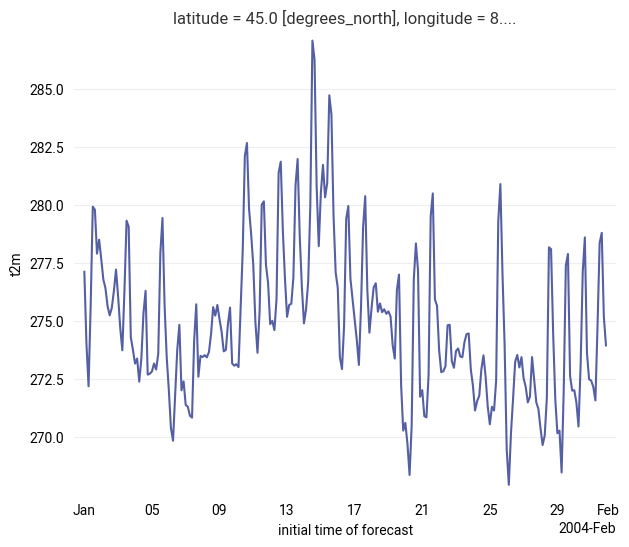

In [69]:
import xarray as xr
# Ottieni il link all'asset Zarr dall'item
zarr_asset_href = item.assets['data'].href  # Assumiamo che l'asset si chiami 'data'

# Carica i dati in xarray
ds = xr.open_zarr(zarr_asset_href)

# Visualizza le informazioni del dataset
ds.mean(['number','step','surface']).t2m.plot()

In [70]:
# tmp_dir.cleanup()